## (a) Vanishing Point and Horizon Line:

Vanishing Point: (578.32, 173.07)


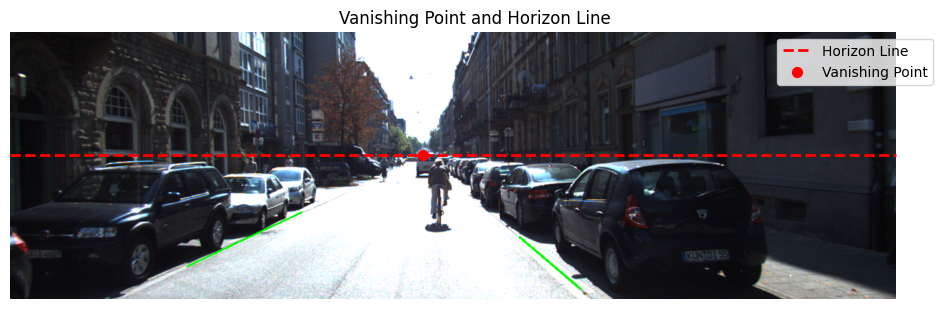

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img_path = "Q3.png"
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_copy = img_rgb.copy()

# Enter the points here: two points for each parallel road edge
# Format: [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
# Example:
points = [(248, 329), (409, 253),  # First line
          (799, 360), (714, 288)]  # Second line

# Convert to homogeneous coordinates
p1 = np.array([*points[0], 1])
p2 = np.array([*points[1], 1])
p3 = np.array([*points[2], 1])
p4 = np.array([*points[3], 1])

# Compute the lines
l1 = np.cross(p1, p2)
l2 = np.cross(p3, p4)

# Compute the vanishing point
vp = np.cross(l1, l2)
vp = vp / vp[2]  # Normalize

print(f"Vanishing Point: ({vp[0]:.2f}, {vp[1]:.2f})")

# Draw the input lines
cv2.line(img_copy, points[0], points[1], (0, 255, 0), 2)
cv2.line(img_copy, points[2], points[3], (0, 255, 0), 2)

# Draw the vanishing point
cv2.circle(img_copy, (int(vp[0]), int(vp[1])), 6, (255, 0, 0), -1)

# Draw the horizon line: horizontal line passing through the vanishing point
x_vals = np.array([0, img.shape[1]])
horizon_y = int(vp[1])
plt.figure(figsize=(12, 6))
plt.imshow(img_copy)
plt.plot(x_vals, [horizon_y, horizon_y], 'r--', linewidth=2, label='Horizon Line')
plt.scatter(vp[0], vp[1], c='red', s=50, label='Vanishing Point')
plt.legend()
plt.title("Vanishing Point and Horizon Line")
plt.axis('off')
plt.show()


## (b) Camera Pitch Angle:

In [2]:
# Camera intrinsic parameters
fy = 980.8141
cy = 233.1966

# Vanishing point (result from previous step)
# Example value: Replace with actual vanishing point from your previous output
vp_y = 180  # Sample value; replace with actual result

# Compute pitch angle
pitch_rad = np.arctan((vp_y - cy) / fy)
pitch_deg = np.degrees(pitch_rad)

print(f"Camera Pitch Angle: {pitch_rad:.4f} rad ({pitch_deg:.2f} degrees)")


Camera Pitch Angle: -0.0542 rad (-3.10 degrees)


## (c) Bird’s Eye View (BEV) Homography:

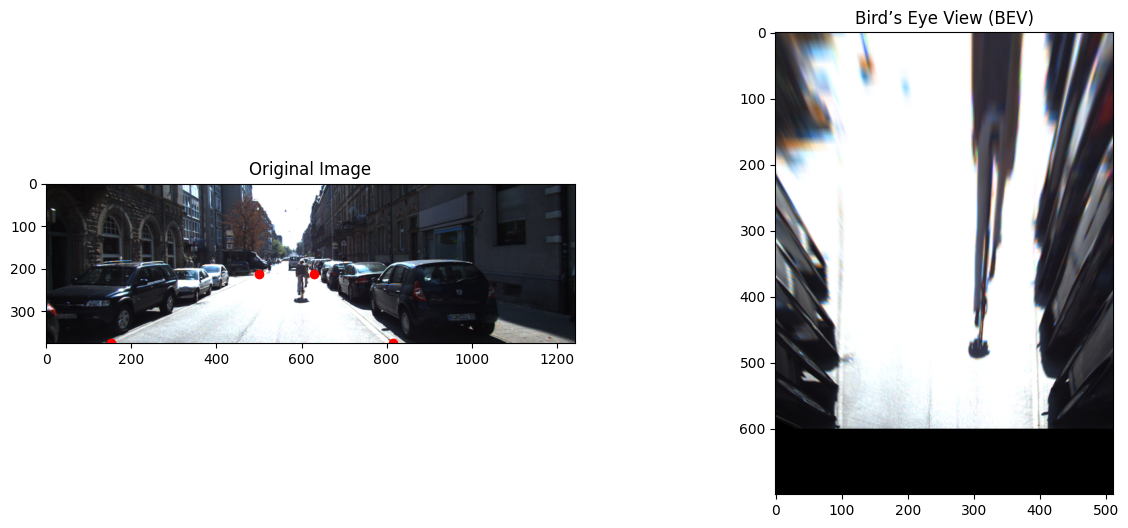

In [3]:
from google.colab import files

# Step 3: Define image and BEV points (these points should be manually adjusted)
# Points on the road in the image (on the ground)
pts_img = np.array([
    [816, 374],  # bottom-right
    [153, 374],  # bottom-left
    [630, 213],  # top-right
    [500, 213]   # top-left
], dtype=np.float32)

# Corresponding points in the BEV (arranged vertically)
pts_bev = np.array([
    [400, 600],  # bottom-right
    [100, 600],  # bottom-left
    [400, 100],  # top-right
    [100, 100]   # top-left
], dtype=np.float32)

# Step 4: Compute the Homography matrix
H, status = cv2.findHomography(pts_img, pts_bev)

# Step 5: Apply the perspective transformation to get BEV
bev_size = (512, 700)  # Size of the BEV image (width, height)
bev_img = cv2.warpPerspective(img_rgb, H, bev_size)

# Display the original image and BEV result
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.scatter(pts_img[:, 0], pts_img[:, 1], c='red')
plt.subplot(1, 2, 2)
plt.imshow(bev_img)
plt.title("Bird’s Eye View (BEV)")
plt.show()


## (d) Road Width and Lane Extraction:

Estimated road width: 15.00 meters
Estimated right lane width: 7.50 meters


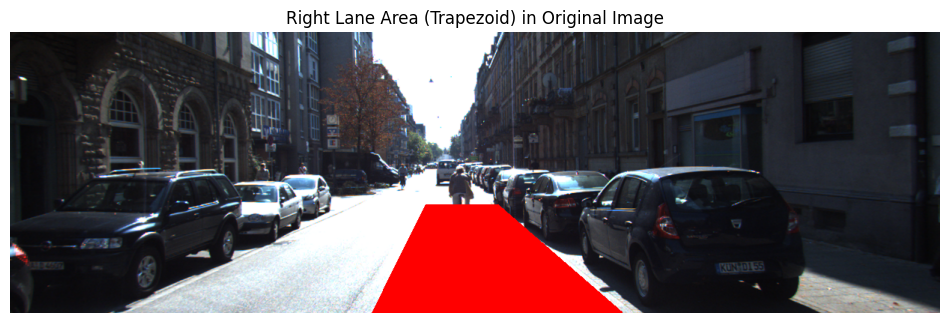

In [4]:
# Parameters
bev_scale_m_per_px = 0.05  # Each pixel in BEV corresponds to how many meters (assumed value - should be adjusted for real data)

# Points in BEV representing the road edges (as defined earlier)
left_point_bev  = np.array([100, 600, 1])  # bottom-left
right_point_bev = np.array([400, 600, 1])  # bottom-right

# Pixel distance between the two road edges in BEV
road_width_px = np.linalg.norm(right_point_bev[:2] - left_point_bev[:2])

# Convert to meters
road_width_m = road_width_px * bev_scale_m_per_px
right_lane_width_m = road_width_m / 2

print(f"Estimated road width: {road_width_m:.2f} meters")
print(f"Estimated right lane width: {right_lane_width_m:.2f} meters")

# -----------------------
# 🔍 Extracting the rightmost lane in the original image:

# Find corresponding points in the original image from BEV using H⁻¹
H_inv = np.linalg.inv(H)

# Points on the right side of the road in BEV
# Assuming the bottom is closer to the camera
right_lane_bev = np.array([
    [250, 600, 1],  # bottom-left of right lane
    [400, 600, 1],  # bottom-right
    [400, 300, 1],  # top-right
    [250, 300, 1]   # top-left of right lane
]).T  # 3×4 for matrix multiplication

# Convert to original image coordinates using H⁻¹
right_lane_img = H_inv @ right_lane_bev
right_lane_img = right_lane_img / right_lane_img[2]  # normalize

# Extract only x, y
pts_img = right_lane_img[:2].T.astype(np.int32)

# Draw the area on the image
img_lane_poly = img_rgb.copy()
cv2.polylines(img_lane_poly, [pts_img], isClosed=True, color=(255, 0, 0), thickness=2)
cv2.fillPoly(img_lane_poly, [pts_img], color=(255, 0, 0))

# Show the result
plt.figure(figsize=(12, 6))
plt.imshow(img_lane_poly)
plt.title("Right Lane Area (Trapezoid) in Original Image")
plt.axis('off')
plt.show()


## (e) Ground Plane Normal Extraction:

In [5]:
# Camera intrinsic parameters
K = np.array([
    [984.2439, 0.0, 690.0],
    [0.0, 980.8141, 233.1966],
    [0.0, 0.0, 1.0]
])

# A point on the horizon line: we assume it's the same vanishing point from earlier
vp = np.array([vp[0], vp[1], 1.0])  # Use actual value from previous context

# Backprojecting the point into a 3D ray in the camera frame
K_inv = np.linalg.inv(K)
ray = K_inv @ vp
ray = ray / np.linalg.norm(ray)  # Normalize the ray

# The ground plane normal is perpendicular to this ray and should point downward
# Assuming the ground is at z=0, the normal should align with the negative Y-axis in camera space
# Therefore, the ground normal can be orthogonal to the ray

n_cam = np.cross(ray, [1, 0, 0])  # A vector perpendicular to the ray (e.g., x-axis)
n_cam = np.cross(n_cam, ray)      # Cross again to get normal vector orthogonal to both

n_cam = n_cam / np.linalg.norm(n_cam)

print("Ground Plane Normal in Camera Frame:")
print(n_cam)


Ground Plane Normal in Camera Frame:
[ 0.9936478  -0.00688553  0.11232381]


## (f) Depth Estimation from Object Detection Using Ground Normal:

In [6]:
n = n_cam  # Should come from the previous step and be normalized

# Camera height from the ground
h = 1.65  # meters

# Contact point of the object with the ground (bottom center of the bicycle box)
# For example, if the bounding box of the bicycle is (xmin, ymin, xmax, ymax) = (300, 200, 360, 400)
bbox = (585, 274, 617, 205)
u = (bbox[0] + bbox[2]) / 2
v = bbox[3]  # Bottom of the box
p_img = np.array([u, v, 1.0])

# Ray direction in camera coordinate system
r = K_inv @ p_img
r = r / np.linalg.norm(r)

# Compute scale (λ)
lambda_ = h / (n @ r)

# Contact point in camera coordinate system
X = lambda_ * r

# Depth (distance to the object along z-axis)
depth = X[2]

print(f"Estimated depth of the bicycle: {depth:.2f} meters")


Estimated depth of the bicycle: 72.78 meters
